# Using GloVe for text classification

In this pre-filled notebook, we use GloVe embeddings to train a classifier for sentiment analysis. For every review in the IMDB dataset we:
1. Tokenize the review into tokens.
2. Get the pre-trained GloVe vector for every token in the review (if they are in the voabulary of GloVe).
3. Average the vectors over the full review.
4. Send the vector through a logistic regression.

This time, we will batch the inputs instead of updating the weights once per epoch.

Before starting, to make your experiments reproducible, make sure to [force the random seed](https://pytorch.org/docs/stable/notes/randomness.html).

In [26]:
import torch
torch.manual_seed(0)

In [27]:
from copy import deepcopy
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

## Using GloVe (1 point)

Let's get familier with GloVe embeddings. We download a small version of GloVe trained of 6 billion words, and use vectors of size 300.

The [torchtext documentation](https://pytorch.org/text/stable/vocab.html#glove) being quite poor, you can find details on the different pre-trained vectors on the [Stanford page](https://nlp.stanford.edu/projects/glove/).

In [28]:
glove = GloVe(name="6B", dim=300)
len(glove.stoi)

400000

In [29]:
glove.stoi["cat"], glove.itos[5450], glove.vectors[glove.stoi["cat"]].shape

(5450, 'cat', torch.Size([300]))

In [30]:
glove.itos[:5]

['the', ',', '.', 'of', 'to']

Notice that punctuations are part of GloVe's vocabulary.

To compare two words, we can look at their cosine similarity.

In [31]:
words = ["cat", "cats", "dog", "fridge"]
for word in words[1:]:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[words[0]]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()  # .item() is used to turn a tensor of a single value to a float
    print(f"{words[0]} x {word} = {similarity}")

cat x cats = 0.6815836429595947
cat x dog = 0.6816746592521667
cat x fridge = 0.09630905091762543


**\[1 point\] Find the closest word to "cat" in the whole vocabulary.**

In [32]:
word = "cat"
similarity = torch.cosine_similarity(
    glove.vectors[glove.stoi[word]].reshape(1, -1),
    glove.vectors,
    dim=1,
)
most_similar = similarity.argsort(descending=True)[1]

print(f"{word} x {glove.itos[most_similar]} = {similarity[most_similar].item()}")

cat x dog = 0.6816746592521667


## Dataset and split

As we keep the test set for final evaluation, we need to split the training set into a training and validation set. We make sure the split is **stratified** by class (same proportion of class in each split).

In [33]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/Users/rb2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /Users/rb2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /Users/rb2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

## Prepare the inputs

### Text processing pipeline (2 points)

For a given entry, we want to
1. Tokenize the text.
2. Get the vectors for each token.
3. Average them.

For tokenization, let's use the "basic_english" tokenizer from torchtext.

In [34]:
tokenizer = get_tokenizer("basic_english", language="en")

**\[2 points\] Fill the `preprocess_text` function so it returns the mean of the GloVe vectors of all the tokens within a review.**

The two following functions can help.
* [torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html)
* [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html)

In [35]:
def vectorize_text(
    text: str, vocabulary: vocab.Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Turn a string into the average of the vectors of its tokens.
    Args:
        text: the input text.
        vocabulary: a pre-trained Vocab object.
        tokenizer: a tokenizer taking a text as input and returning a list of tokens.
    Returns:
        The average tensor over the tokens of the whole text.
    """
    tokens = tokenizer(text)
    vectors = [vocabulary[token] for token in tokens]
    return torch.stack(vectors).mean(dim=0)

In [36]:
text_pipeline = partial(vectorize_text, vocabulary=glove, tokenizer=tokenizer)
assert text_pipeline("some text.").shape == torch.Size([300])

Now we turn our 3 sets into vectors and labels.

Our data are quite small, so we can keep everything in RAM.

In [37]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

### Batch processing (1 point)

Instead of doing one update per epoch, we feed the model batches of texts between each update. To do so, we use a simple data generator.

**\[1 point\] Fill the generator function.**


In [38]:
def data_generator(
    X: List[torch.tensor], y: List[int], batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    X, y = shuffle(X, y)
    for i in range(0, len(X), batch_size):
        yield torch.stack(X[i : i + batch_size]), torch.tensor(y[i : i + batch_size])

In [39]:
train_gen = lambda: data_generator(X_train, y_train, batch_size=32)
for X, y in train_gen():
    assert X.shape == torch.Size([32, 300])
    assert y.shape == torch.Size([32])
    break

## The classifier (1 point)

We create a very simple classifier corresponding a logistic regression.

**\[1 point\] Fill the classifier's code. The forward function needs to return a logit and not the output of a sigmoid.**

In [40]:
class SimpleClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        super().__init__()
        self.linear = nn.Linear(embedding_size, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        return self.linear(x)

## Training (3 points)

We put everything above together and train the classifier.

In [41]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [42]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

**\[3 points\] Fill the following cells. Make sure you save the best model evaluated on the validation set.**
* The `deepcopy` function might help.

In [43]:
model = SimpleClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters())

In [46]:

# use the deepcopy function might help to save the best model on the validation set

nb_epochs = 50
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf

for epoch in tqdm(range(nb_epochs)):

    # training
    model.train()
    train_loss = 0
    for X, y in train_gen():
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat.squeeze(), y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(X_train)
    train_losses.append(train_loss)
    
    # validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X, y in valid_gen():
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat.squeeze(), y.float())
            valid_loss += loss.item()
    valid_loss /= len(X_valid)
    valid_losses.append(valid_loss)
    
    # save the best model
    if valid_loss < best_validation_loss:
        best_validation_loss = valid_loss
        best_model = deepcopy(model)
    


  0%|          | 0/50 [00:00<?, ?it/s]

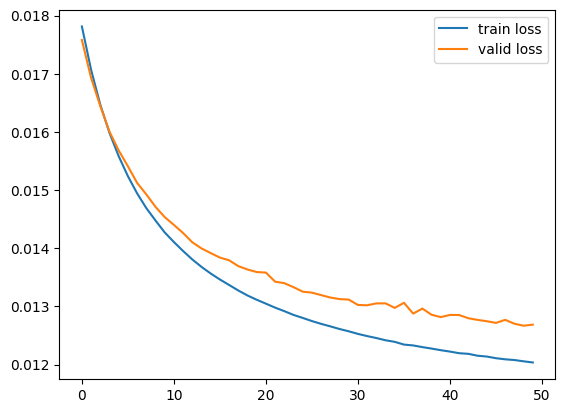

In [47]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

## Evaluation (3 point)

**\[1 point\] Compute the accuracy for the 3 splits (training, validation, test).**

In [48]:
# compute the accuracy for the 3 splits (training, validation, test)

with torch.no_grad():
    model.eval()
    y_hat_train = model(torch.stack(X_train).to(device)).squeeze().cpu()
    y_hat_valid = model(torch.stack(X_valid).to(device)).squeeze().cpu()
    y_hat_test = model(torch.stack(X_test).to(device)).squeeze().cpu()

y_hat_train = (y_hat_train > 0).numpy().astype(int)
y_hat_valid = (y_hat_valid > 0).numpy().astype(int)
y_hat_test = (y_hat_test > 0).numpy().astype(int)

from sklearn.metrics import accuracy_score

print(f"Train accuracy: {accuracy_score(y_train, y_hat_train)}")
print(f"Validation accuracy: {accuracy_score(y_valid, y_hat_valid)}")
print(f"Test accuracy: {accuracy_score(y_test, y_hat_test)}")

Train accuracy: 0.83615
Validation accuracy: 0.827
Test accuracy: 0.8258


**\[1 point\] For two wrongly classified samples, try guessing why the model was wrong.**

In [49]:
def find_misclassified_texts(
    X: List[str], y: List[int], y_hat: List[int]
) -> List[Tuple[str, int, int]]:
    """
    Find the misclassified texts.
    Args:
        X: the input texts.
        y: the true labels.
        y_hat: the predicted labels.
    Returns:
        A list of tuples (text, true label, predicted label).
    """
    return [(text, true, pred) for text, true, pred in zip(X, y, y_hat) if true != pred]

misclassified = find_misclassified_texts(test_df["text"], y_test, y_hat_test)
print(f"Number of misclassified texts: {len(misclassified)}")

# 2 examples of misclassified texts
for text, true, pred in misclassified[:2]:
    print(f"True label: {true}, predicted label: {pred}")
    print(text)
    print()

Number of misclassified texts: 4355
True label: 0, predicted label: 1
First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!

True label: 0, predicted label: 1
Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can tell Isaac has a real pa

**\[1 point\] Code a `predict` function which take some text as input and returns a prediction class and score (the output of the sigmoid).**

In [50]:
def predict(
    text: str,
    text_pipeline: Callable[[str], torch.Tensor],
    model: nn.Module,
    device: str,
) -> Tuple[int, float]:
    """
    Return the predicted class and score for a given input.
    Args:
        text: a given review.
        text_pipeline: a function taking a text as input and returning a tensor (model's input).
        model: a pre-trained model.
        device: the device on which the computation occurs.
    Returns:
        A tuple (label, score).
    """
    model.eval()
    with torch.no_grad():
        X = text_pipeline(text).to(device)
        y_hat = model(X)
        score = torch.sigmoid(y_hat).item()
        label = int(score > 0.5)
    return label, score

In [51]:
text = "In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle."
predict(text, text_pipeline, model, device)

(0, 0.3531131446361542)

## Bonus

Modify the classifier. Instead of using a simple logistic regression, create a multilayer perceptron. Something like `input -> linear(embedding_size, 128) -> activation function -> linear(128, nb_classes) -> output`, for a two layer perceptron.

For the activation function, you can use [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) or [another non-linear activation function](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) of your choice.

Train your new classifier, look at the loss, and compare its accuracy with the logistic regression. Keep the model with the best validation loss.